In [1]:
# 导入需要的依赖包
import numpy as np
import matplotlib.pyplot as plt
import paddle
import paddle.fluid as fluid 
import pandas as pd

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
f_data = pd.read_csv('data/flights.csv')
f_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


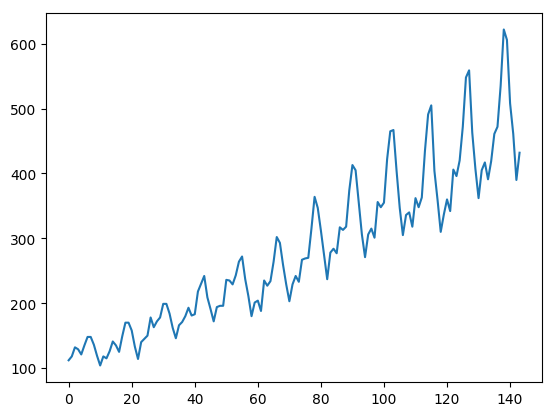

In [4]:
plt.plot(f_data['passengers'])

In [5]:
data_1 = f_data['passengers'].values.astype('float32')

# 划分数据集
test_data_size = 12

train_data = data_1[:-test_data_size]
test_data = data_1[-test_data_size:]

In [6]:
# 对训练集进行归一化
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1,1))

In [7]:
paddle.set_device('cpu')#定义使用gpu运算

Place(cpu)

In [8]:
# 创建继承自paddle.io.Dataset的自定义的数据集
class MyDataset(paddle.io.Dataset):
    '''
    步骤一：继承paddle.io.Dataset类
    '''
    def __init__(self,normalized_train_set):
        '''
        步骤二：实现构造函数
        '''
        super(MyDataset, self).__init__()
        self.train_set_data_X = []
        self.train_set_data_Y = []
        self.transform(normalized_train_set)
    def transform(self,data):
        for i in range(12,len(data)):
            self.train_set_data_X.append(np.array(data[i-12:i].reshape(-1,1)))
            self.train_set_data_Y.append(np.array(data[i]))
            
    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据）
        """
        data = self.train_set_data_X[index]
        label = self.train_set_data_Y[index]
        return data,label
    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.train_set_data_X)

In [9]:
# 实例化数据集
data_set = MyDataset(train_data_normalized)

In [10]:
# 时序预测，不能调换顺序
train_loader = paddle.io.DataLoader(data_set,batch_size=10,shuffle=False)

In [11]:
# 定义网络结构
class StockNet(paddle.nn.Layer):
    def __init__(self):
        super(StockNet, self).__init__()
        self.lstm = paddle.nn.LSTM(input_size=1,
                                   hidden_size=50,
                                   num_layers=4,
                                   dropout=0.2,
                                   time_major=False)  #要求输入的形状是[batch_size,time_steps,input_size]
        self.fc = paddle.nn.Linear(in_features=50,out_features=1)

    def forward(self, inputs):
        outputs,final_states = self.lstm(inputs)  # 使用最后一层的最后一个step的输出作为线性层的输入，final_states是个元组，第一个是h(中间输出)的参数，第二个是c(日记)的参数
        # final_states[0][3]表示最后一层隐藏层h的参数
        y = self.fc(final_states[0][2])  # 输入：形状为 [batch_size,∗,in_features] 的多维Tensor。
        return y

In [12]:
model = StockNet()

In [13]:
# 优化器以及损失函数
optim = paddle.optimizer.RMSProp(parameters=model.parameters(),learning_rate=0.01)
loss_fn = paddle.nn.MSELoss()

In [14]:
# 模型的训练
epochs = 1000

for epoch in range(1, epochs+1):
    for batch_id,data in enumerate(train_loader()):
        #梯度清0
        optim.clear_grad()
        x_data = data[0]  # 训练数据
        y_data = data[1]  # 训练数据标签
        predicts = model(x_data)  # 预测结果
        # 计算损失 等价于prepare中的loss设置
        loss = loss_fn(predicts,y_data.reshape((-1,1)))
        # 反向传播
        loss.backward()
        if (batch_id+1)%12==0:
            if epoch % 50 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id+1, loss.numpy()))
        # 更新参数
        optim.step()
        

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/framework.py:3983: DeprecationWarning: Op `rmsprop` is executed through `append_op` under the dynamic mode, the corresponding API implementation needs to be upgraded to using `_C_ops` method.
  DeprecationWarning,


epoch: 50, batch_id: 12, loss is: [0.0398009]
epoch: 100, batch_id: 12, loss is: [0.00540182]
epoch: 150, batch_id: 12, loss is: [0.01543843]
epoch: 200, batch_id: 12, loss is: [0.00932209]
epoch: 250, batch_id: 12, loss is: [0.00588918]
epoch: 300, batch_id: 12, loss is: [0.01445038]
epoch: 350, batch_id: 12, loss is: [0.0048099]
epoch: 400, batch_id: 12, loss is: [0.0260403]


In [15]:
tmp_input1 = np.hstack((train_data_normalized[-12:].reshape(-1,),test_data_normalized.reshape(-1,)))
tmp_input1 = tmp_input1.astype('float32')
test_data1 = MyDataset(tmp_input1)
test_loader1 = paddle.io.DataLoader(test_data1,batch_size=12,drop_last=False)
model.eval()
result1 = None
for batch_id_1,data in enumerate(test_loader1()):
    with paddle.no_grad():
        x_data = data[0]
        predicts = model(x_data)
        result1 = predicts.reshape((-1,))

In [16]:
result1

Tensor(shape=[12], dtype=float32, place=Place(cpu), stop_gradient=True,
       [0.66318977, 0.57587230, 0.46594611, 0.40111595, 0.42051533, 0.44638324,
        0.66203094, 0.91882396, 0.88424563, 0.55488670, 0.46567270, 0.36973470])

In [17]:
acu = scaler.inverse_transform(np.array(result1).reshape(-1, 1))

In [18]:
acu

array([[543.86005],
       [523.60236],
       [498.0995 ],
       [483.0589 ],
       [487.55957],
       [493.56088],
       [543.5911 ],
       [603.1671 ],
       [595.14496],
       [518.7337 ],
       [498.03604],
       [475.77844]], dtype=float32)

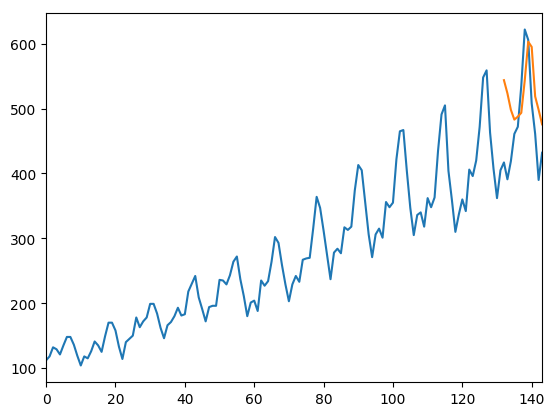

In [19]:
x = np.arange(132, 144, 1)
plt.autoscale(axis='x', tight=True)
plt.plot(f_data['passengers'])
plt.plot(x,acu)
plt.show()